# Init

In [1]:
import cv2 as cv
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.ndimage
import skimage.filters  # for intellisense
import skimage.util  # for intellisense

In [5]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

In [6]:
rgb = cv.imread('robot.bmp')[..., ::-1]
rgb = skimage.util.img_as_float32(rgb)
rgb.shape, rgb.dtype, rgb.min(), rgb.max()

((234, 160, 3), dtype('float32'), 0.0, 1.0)

In [7]:
gray = cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
gray = skimage.util.img_as_float32(gray)
gray.shape, gray.dtype, gray.min(), gray.max()

((234, 160), dtype('float32'), 0.0, 1.0)

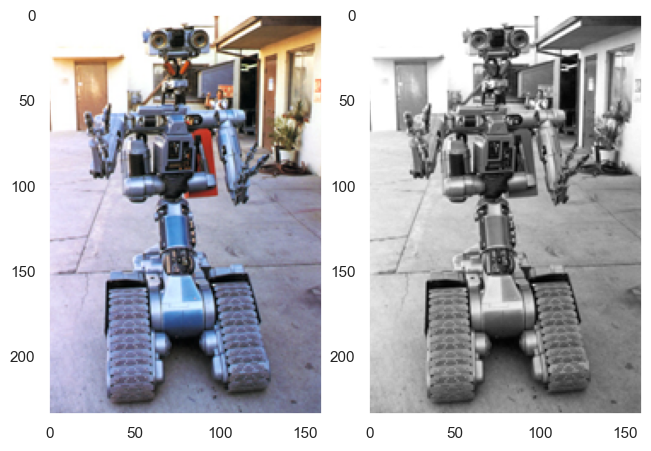

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0, vmax=1);

# Spatial processing

# Additive noise model

We assume that the noise value $\nu$ at each pixel is an independent random variable with zero and standard deviation $\sigma$ and that the observed value of image $I(x,y)$ at position $(x,y)$ is a sum of the true (but unknown) value $\bar{I}(x,y)$ and noise $\nu$
$$
I(x,y) = \bar{I}(x,y) + \nu
$$
Usually, $\nu$ comes from a normal (Gaussian) distribution, i.e. $\nu\sim\mathcal{N}(0,\sigma)$.

In [9]:
rgb_gn = skimage.util.random_noise(rgb, mode='gaussian', var=0.01)
rgb_gn.shape, rgb_gn.dtype, rgb_gn.min(), rgb_gn.max()

((234, 160, 3), dtype('float64'), 0.0, 1.0)

In [10]:
gray_gn = skimage.util.random_noise(gray, mode='gaussian', var=0.01)
gray_gn.shape, gray_gn.dtype, gray_gn.min(), gray_gn.max()

((234, 160), dtype('float64'), 0.0, 1.0)

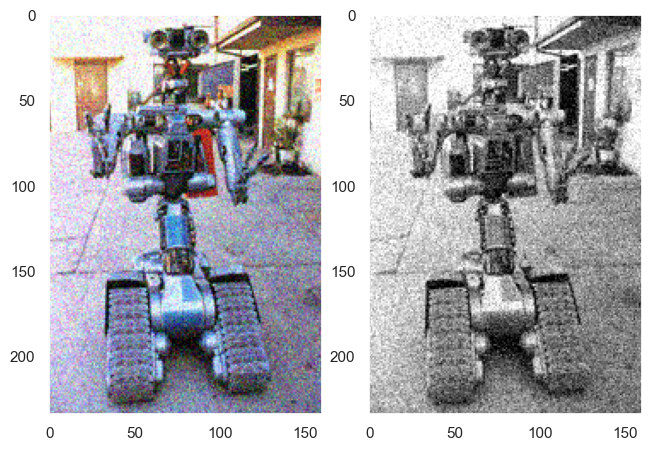

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb_gn)
axes[1].imshow(gray_gn, cmap='gray', vmin=0., vmax=1.);

# Noise filtering using multiple image averaging

If we are able to capture the same scene $N$ times as images $I_n$, we may estimate the true value of the image as
$$
\hat{I}(x,y) = \frac{1}{N}\cdot\sum_{n=1}^{N}{I_n(x,y)} + \frac{1}{N}\cdot\sum_{n=1}^{N}{\nu_{n,x,y}}
$$
The second term describes the noise, which, under the assumption that the expected value of $\nu$ is $\text{E}(\nu) = 0$ and $\text{var}(\nu) = \sigma^2$, is again a random value with zero mean and a standard deviation $\sigma / N$. As $N \rightarrow \infty$, $\sigma / N \rightarrow 0$.

Repeated capture (burst) of the same scene and then averaging is what basically happens in many mobile cameras to reduce noise especially under insufficient lightning conditions.

In [12]:
rgb_gns = np.array([
    skimage.util.random_noise(rgb, mode='gaussian', var=0.01)
    for i in range(10)
])
rgb_gns.dtype, rgb_gns.shape, rgb_gns.min(), rgb_gns.max()

(dtype('float64'), (10, 234, 160, 3), 0.0, 1.0)

In [13]:
rgb_gns_r = rgb_gns.mean(axis=0)
rgb_gns_r.shape, rgb_gns_r.shape, rgb_gns_r.min(), rgb_gns_r.max()

((234, 160, 3), (234, 160, 3), 0.0033958838577815204, 1.0)

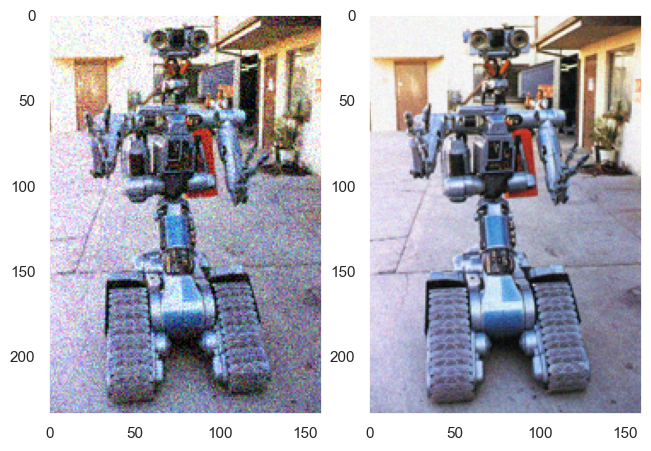

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb_gn)
axes[1].imshow(rgb_gns_r);

# Noise filtering using local averaging (image smoothing)

More often than not, we are stuck with only one image and avering is then performed in a local neighborhood. Assuming a square region of size $K \times K$:
$$
\hat{I}(x,y) = \frac{1}{K^2}\cdot\sum_{i=-K/2}^{+K/2}\sum_{j=-K/2}^{+K/2}{I(x+i,y+j)}
$$
Results are acceptable if the noise is in smaller size than the smallest objects of interest in the image, but **blurring of edges** is a serious disadvantage.

In [15]:
def local_average(img: np.ndarray, wnd_size: int = 3) -> np.ndarray:
    img_r = np.zeros_like(img)
    half = wnd_size // 2
    for row in range(half, img.shape[0] - half):
        for col in range(half, img.shape[1] - half):
            window = img[row-half:row+half+1, col-half:col+half+1]
            img_r[row, col] = window.mean(axis=(0, 1))
    return img_r

In [16]:
gray_gn_r = local_average(gray_gn, wnd_size=3)
gray_gn_r.shape, gray_gn_r.shape, gray_gn_r.min(), gray_gn_r.max()

((234, 160), (234, 160), 0.0, 1.0)

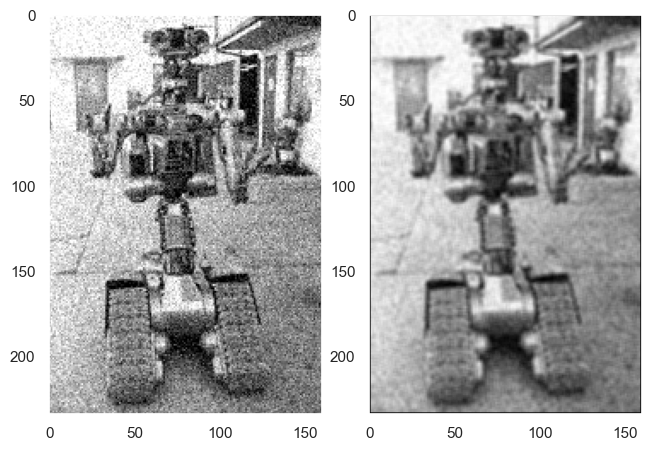

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray_gn, cmap='gray', vmin=0, vmax=1)
axes[1].imshow(gray_gn_r, cmap='gray', vmin=0, vmax=1);

In [18]:
rgb_gn_r = local_average(rgb_gn, wnd_size=3)
rgb_gn_r.shape, rgb_gn_r.shape, rgb_gn_r.min(), rgb_gn_r.max()

((234, 160, 3), (234, 160, 3), 0.0, 1.0)

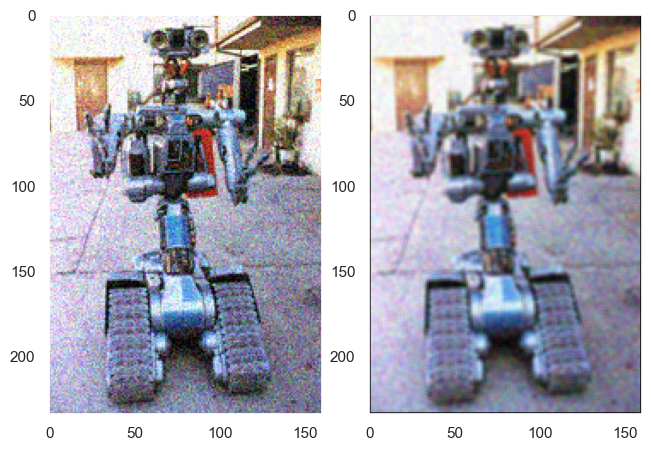

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(rgb_gn)
axes[1].imshow(rgb_gn_r);

# Convolution

Discrete 2D convolution is
$$
I'(x,y) = \sum_{i=-\infty}^{+\infty}\sum_{j=-\infty}^{+\infty}{I(x-i,y-j) \cdot h(i,j)}
$$
or
$$
I' = I * h
$$

Illustration of convolution:

<img src="figures/spatial_filtering-convolution_animation.gif" alt="Convolution" style="height: 4in;"/>

**Convolution properties**

Commutativity
$$
I * h = h * I
$$

Linearity
$$
(s \cdot I) * h = I * (s \cdot h) = s \cdot (I * h) \\
(I_1 + I_2) * h = (I_1 * h) + (I_2 * h)
$$

Associativity
$$
(I * h_1) * h_2 = I * (h_1 * h_2)
$$

In [20]:
def conv2d(gray: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    out = np.zeros_like(gray)
    img_h, img_w = gray.shape
    k_h, k_w = kernel.shape
    for y in range(k_h // 2, img_h - k_h // 2):
        for x in range(k_w // 2, img_w - k_w // 2):
            window = gray[y-k_h//2:y+k_h//2+1, x-k_w//2:x+k_w//2+1]
            out[y, x] = np.sum(kernel * window)
    return out

In [21]:
kernel = 1/9 * np.ones((3, 3))
kernel

array([[0.111, 0.111, 0.111],
       [0.111, 0.111, 0.111],
       [0.111, 0.111, 0.111]])

In [22]:
gray_gn_rc = conv2d(gray_gn, kernel)
gray_gn_rc.shape, gray_gn_rc.shape, gray_gn_rc.min(), gray_gn_rc.max()

((234, 160), (234, 160), 0.0, 1.0)

##

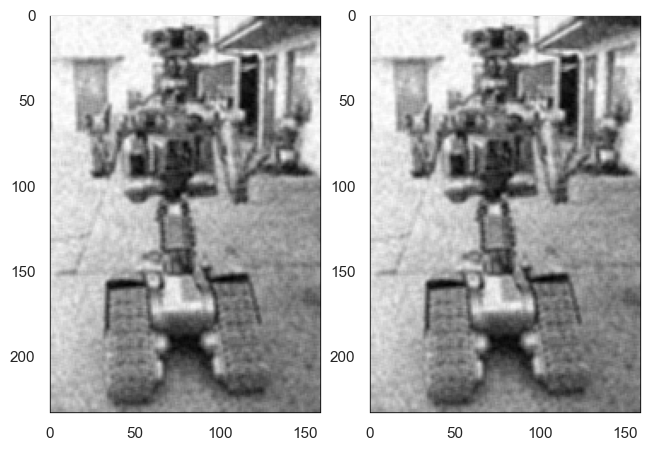

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray_gn_r, cmap='gray', vmin=0, vmax=1)
axes[1].imshow(gray_gn_rc, cmap='gray', vmin=0, vmax=1);

In [24]:
np.sum(np.abs(gray_gn_rc - gray_gn_r))

1.9408901569262227e-12

## Choice of kernel: blur, edges, emboss, identity, outline, sharpen

In [25]:
kernels = {
    'identity': np.array([
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
    ]),
    'local averaging': np.array([
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
    ]),
    'Gaussian-like averaging (blurring)': np.array([
        [1/16, 1/8, 1/16],
        [1/8,  1/4, 1/8],
        [1/16, 1/8, 1/16],
    ]),
    'sharpen': np.array([
        [ 0., -1.,  0.],
        [-1.,  5., -1.],
        [ 0., -1.,  0.],
    ]),
    'emboss': np.array([
        [-2., -1., 0.],
        [-1.,  1., 1.],
        [0.,   1., 2.],
    ]),
    'outline': np.array([
        [-1., -1., -1.],
        [-1.,  8., -1.],
        [-1., -1., -1.],
    ]),
    'horizontal Sobel edges': np.array([
        [-1., -2., -1.],
        [0.,  0.,  0. ],
        [1.,  2.,  1. ],
    ]),
    'vertical Sobel edges': np.array([
        [-1., 0., 1.],
        [-2., 0., 2.],
        [-1., 0., 1.],
    ]),
}

In [26]:
gray_convs = {
    name: conv2d(gray, kernel)
    for name, kernel in kernels.items()
}

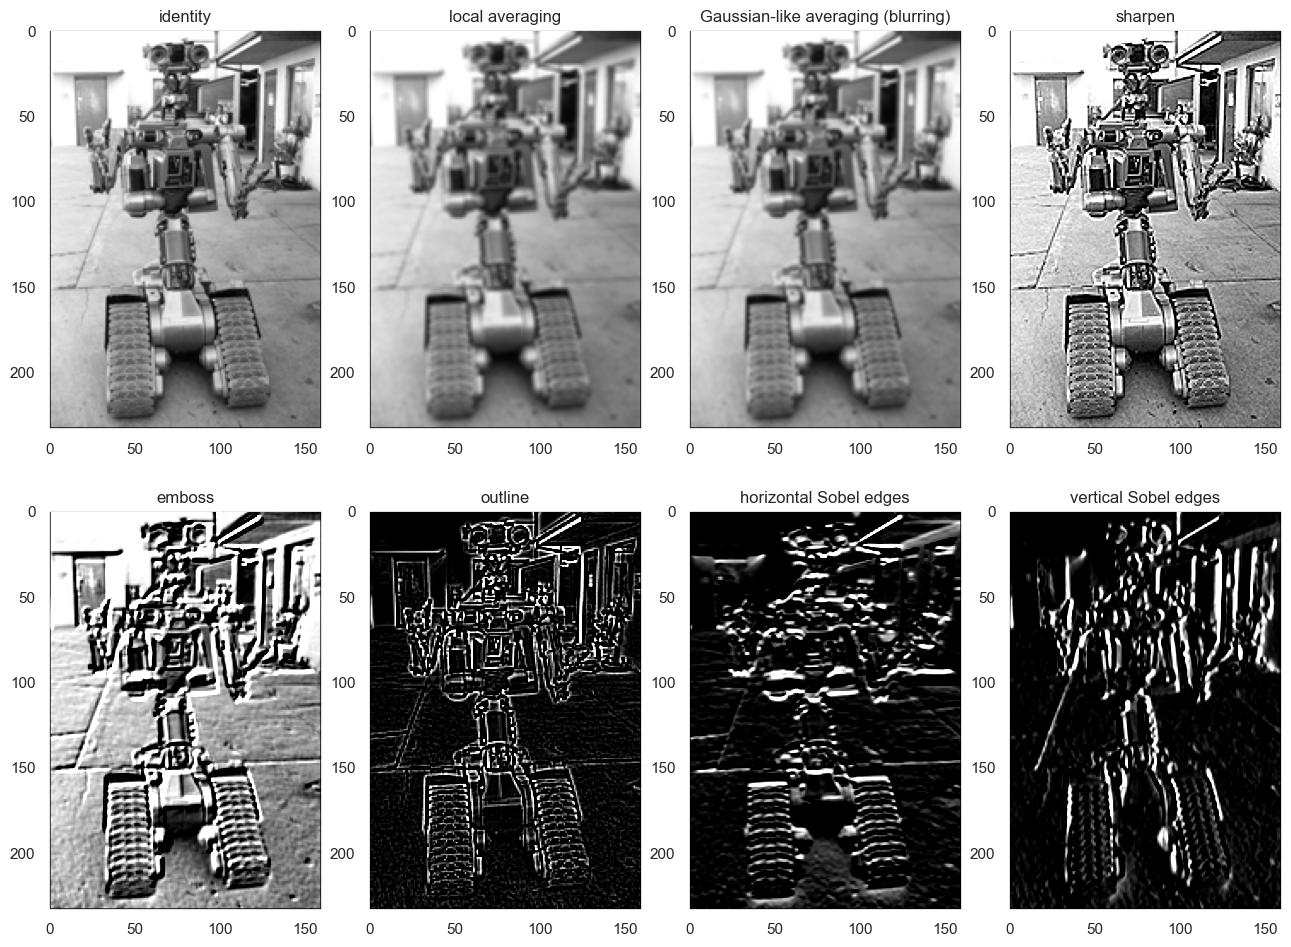

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, layout='constrained', figsize=tuple(2*np.array(plt.rcParams['figure.figsize'])))
for i, (name, gray_conv) in enumerate(gray_convs.items()):
    axes.flat[i].imshow(gray_conv, cmap='gray', vmin=0, vmax=1)
    axes.flat[i].set_title(name)

## Implementations of convolution: scipy

In [28]:
%%time

gray_gn_rscp = scipy.signal.convolve2d(
    gray_gn,
    kernels['local averaging'],
    mode = 'full',
    boundary = 'symm'
#     fillvalue=0
)
gray_gn_rscp.shape, gray_gn_rscp.dtype, gray_gn_rscp.min(), gray_gn_rscp.max()

CPU times: total: 0 ns
Wall time: 80.5 ms


((236, 162), dtype('float64'), 0.004542576346835971, 1.0000000000000002)

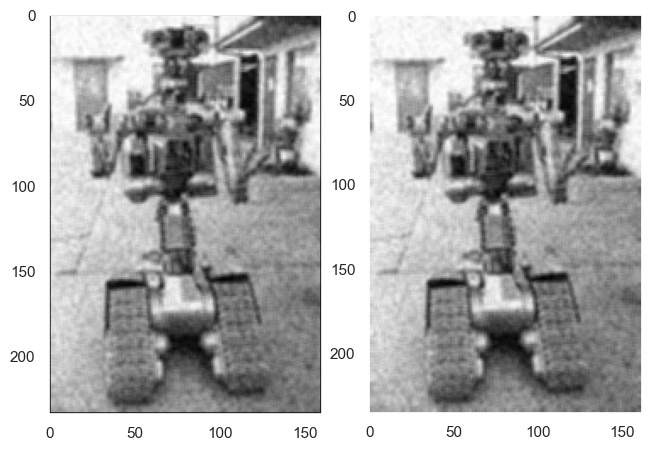

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, layout='constrained')
axes[0].imshow(gray_gn_rc, cmap='gray', vmin=0, vmax=1)  # using conv2d
axes[1].imshow(gray_gn_rscp, cmap='gray', vmin=0, vmax=1);  # using scipy.signal.convolve

### RGB: filter each channel independently

In [30]:
%%time

rgb_gn_rscp = np.zeros_like(rgb_gn)
for c in range(3):
    rgb_gn_rscp[:, :, c] = scipy.signal.convolve2d(
        rgb_gn[:, :, c],
        kernel,
        boundary='symm',
        mode='same'
    )

CPU times: total: 0 ns
Wall time: 6.07 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


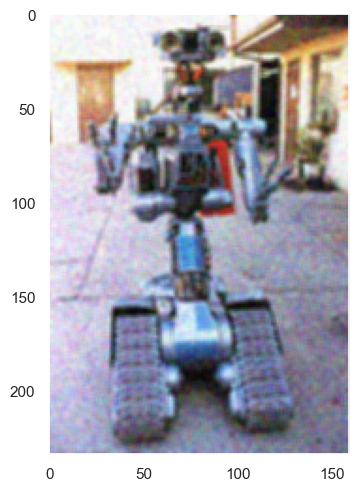

In [31]:
plt.imshow(rgb_gn_rscp, cmap='gray', vmin=0, vmax=1);

In [32]:
# THIS DOES SOMETHING DIFFERENT!!!
tmp_ = scipy.signal.convolve(
    rgb_gn,
    np.stack((kernel, kernel, kernel)) / 3,
#     boundary='symm',  # it doesn't support this argument
    mode='same',
)
tmp_.shape

(234, 160, 3)

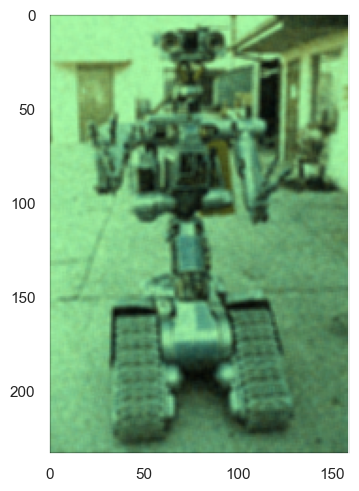

In [33]:
plt.imshow(tmp_, cmap='gray', vmin=0, vmax=1);

## Implementations of convolutions: OpenCV

In [34]:
gray_gn_rcv = cv.filter2D(gray_gn, -1, kernel)

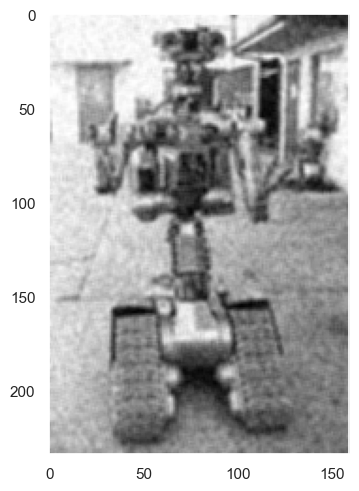

In [35]:
plt.imshow(gray_gn_rcv, cmap='gray', vmin=0, vmax=1);

In [36]:
rgb_gn_rcv = cv.filter2D(rgb_gn, -1, kernel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


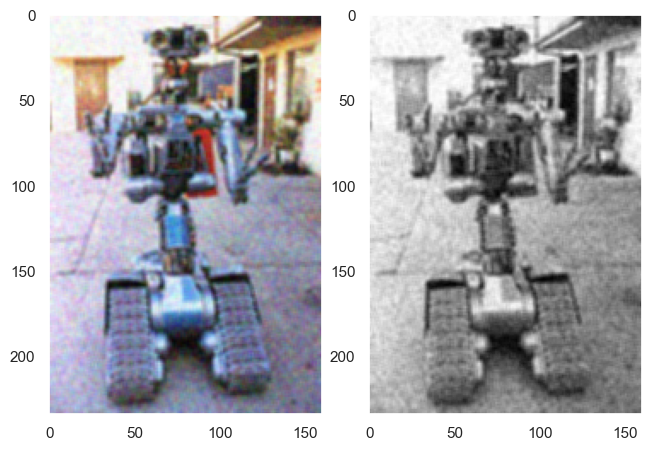

In [37]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb_gn_rcv);
axes[1].imshow(gray_gn_rcv, cmap='gray', vmin=0, vmax=1);

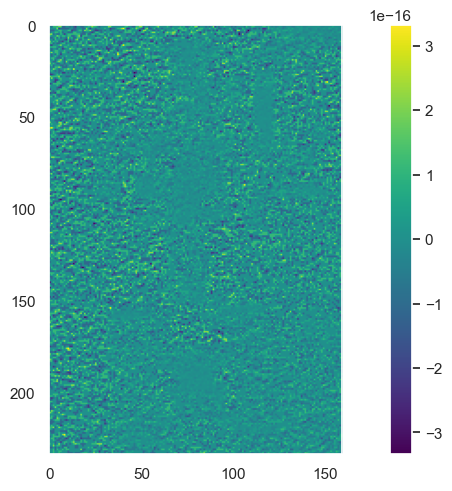

In [38]:
plt.imshow(
    scipy.signal.convolve2d(gray_gn_rcv, kernel, boundary='symm', mode='same')
    -
    cv.filter2D(gray_gn_rcv, -1, kernel, borderType=cv.BORDER_REFLECT)
)
plt.colorbar();

# Separable filters

In [39]:
kernel_1d = scipy.signal.windows.gaussian(11, 2.)
kernel_1d

array([0.044, 0.135, 0.325, 0.607, 0.882, 1.   , 0.882, 0.607, 0.325, 0.135, 0.044])

In [40]:
kernel_1d /= kernel_1d.sum()
kernel_1d

array([0.009, 0.027, 0.065, 0.122, 0.177, 0.201, 0.177, 0.122, 0.065, 0.027, 0.009])

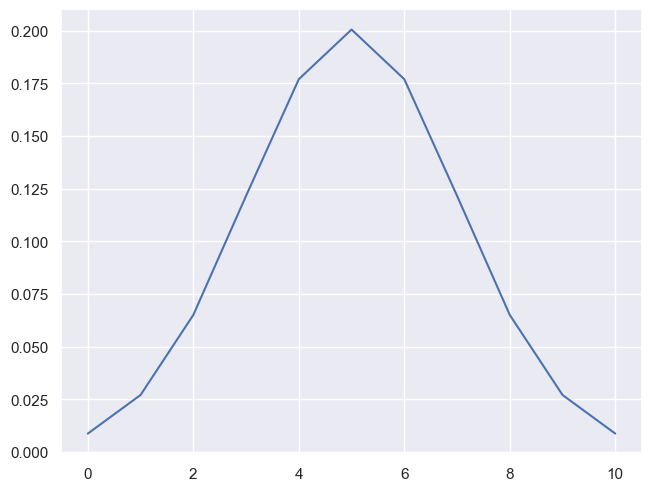

In [41]:
plt.plot(kernel_1d);
plt.grid();

In [42]:
kernel_1d[:, None].shape, kernel_1d[None, :].shape

((11, 1), (1, 11))

In [43]:
kernel_2d = np.dot(kernel_1d[:, None], kernel_1d[None, :])
kernel_2d.shape, kernel_2d.sum()

((11, 11), 1.0000000000000004)

In [44]:
np.set_printoptions(precision=2, floatmode='fixed')
kernel_2d

array([[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.01, 0.01, 0.02, 0.02, 0.02, 0.01, 0.01, 0.00, 0.00],
       [0.00, 0.00, 0.01, 0.02, 0.03, 0.04, 0.03, 0.02, 0.01, 0.00, 0.00],
       [0.00, 0.01, 0.01, 0.02, 0.04, 0.04, 0.04, 0.02, 0.01, 0.01, 0.00],
       [0.00, 0.00, 0.01, 0.02, 0.03, 0.04, 0.03, 0.02, 0.01, 0.00, 0.00],
       [0.00, 0.00, 0.01, 0.01, 0.02, 0.02, 0.02, 0.01, 0.01, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.01, 0.01, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

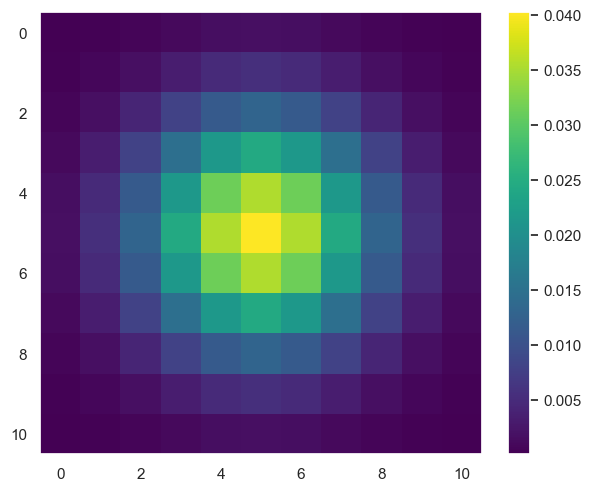

In [45]:
plt.imshow(kernel_2d)
plt.colorbar();

In [46]:
gray_gn_s1x2d = scipy.ndimage.convolve(gray_gn, kernel_2d)

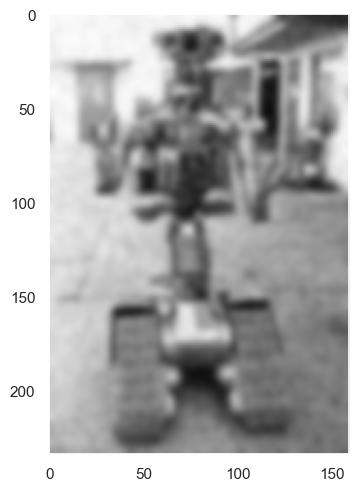

In [47]:
plt.imshow(gray_gn_s1x2d, cmap='gray', vmin=0, vmax=1);

In [48]:
def conv2d_sep(img: np.ndarray, kernel1: np.ndarray, kernel2: np.ndarray) -> np.ndarray:
    out = scipy.ndimage.convolve(img, kernel1)
    out = scipy.ndimage.convolve(out, kernel2)
    return out

In [49]:
gray_gn_s2x1d = conv2d_sep(gray_gn, kernel_1d[None, :], kernel_1d[:, None])  # convolve rows then columns

In [50]:
fig.get_size_inches()[1], axes[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted()).height

IndexError: index 2 is out of bounds for axis 0 with size 2

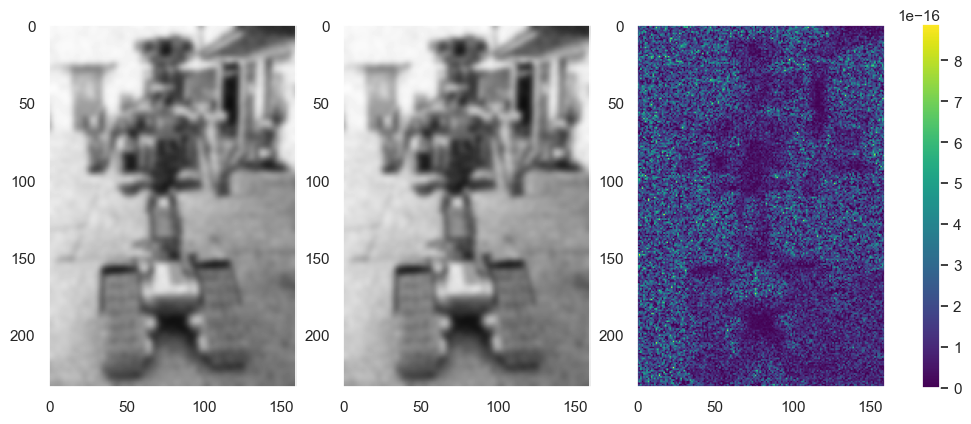

In [51]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(gray_gn_s1x2d, cmap='gray', vmin=0, vmax=1);
axes[1].imshow(gray_gn_s2x1d, cmap='gray', vmin=0, vmax=1);
im2 = axes[2].imshow(np.abs(gray_gn_s2x1d - gray_gn_s1x2d));
fig.colorbar(im2, ax=axes[2], shrink=axes[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted()).height/fig.get_size_inches()[1]);

In [52]:
%timeit scipy.ndimage.convolve(gray_gn, kernel_2d)

4.91 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%timeit conv2d_sep(gray_gn, kernel_1d[None, :], kernel_1d[:, None])

901 µs ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [54]:
def conv2d_sep_faster(img: np.ndarray, kernel1: np.ndarray, kernel2: np.ndarray) -> np.ndarray:
    # scipy.ndimage.convolve1d is faster than scipy.ndimage.convolve
    out = scipy.ndimage.convolve1d(img.T, kernel1)
    out = scipy.ndimage.convolve1d(out.T, kernel2)
    return out

In [55]:
gray_gn_s2x1d_ = conv2d_sep_faster(gray_gn, kernel_1d, kernel_1d)

In [56]:
%timeit conv2d_sep_faster(gray_gn, kernel_1d, kernel_1d)

485 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


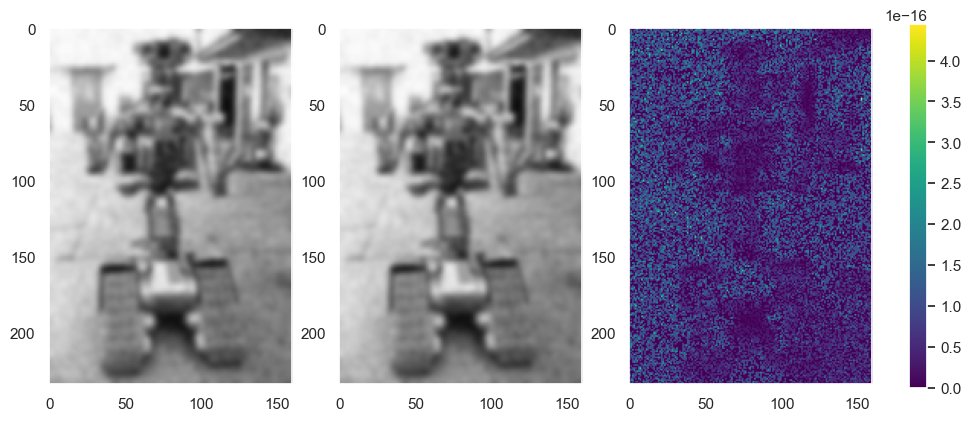

In [57]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(gray_gn_s2x1d, cmap='gray', vmin=0, vmax=1);
axes[1].imshow(gray_gn_s2x1d_, cmap='gray', vmin=0, vmax=1);
im2 = axes[2].imshow(np.abs(gray_gn_s2x1d - gray_gn_s2x1d_));
fig.colorbar(im2, ax=axes[2], shrink=axes[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted()).height/fig.get_size_inches()[1]);

# Salt & pepper noise: non-linear median filter

In [58]:
gray_sp = skimage.util.random_noise(gray, mode='s&p', amount=0.05)
rgb_sp = skimage.util.random_noise(rgb, mode='s&p', amount=0.05)

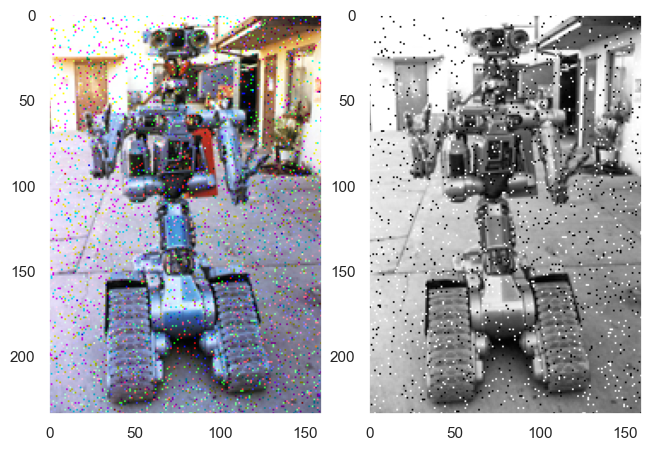

In [59]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb_sp);
axes[1].imshow(gray_sp, cmap='gray', vmin=0, vmax=1);

In [60]:
gray_sp_ravg = scipy.ndimage.convolve(gray_sp, 1/9*np.ones((3, 3)))

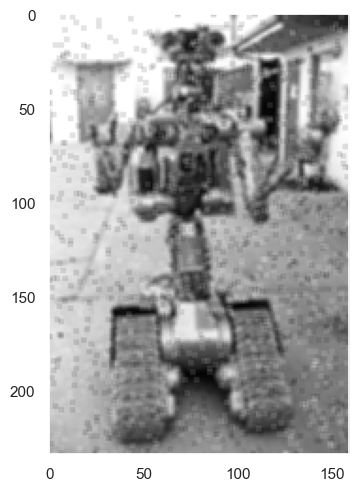

In [61]:
plt.imshow(gray_sp_ravg, cmap='gray', vmin=0, vmax=1);

## Local median of 3x3 neighborhood

In [62]:
def median_filter(gray: np.ndarray, wnd_size: int) -> np.ndarray:
    gray_sp_rmed = np.zeros_like(gray_sp)
    half = wnd_size // 2
    for row in range(half, gray_sp.shape[0] - half):
        for col in range(half, gray_sp.shape[1] - half):
            window = gray_sp[row-half:row+half+1, col-half:col+half+1]
            gray_sp_rmed[row, col] = np.median(window)
    return gray_sp_rmed

In [63]:
gray_sp_rmed = median_filter(gray_sp, 3)
gray_sp_rmed.shape

(234, 160)

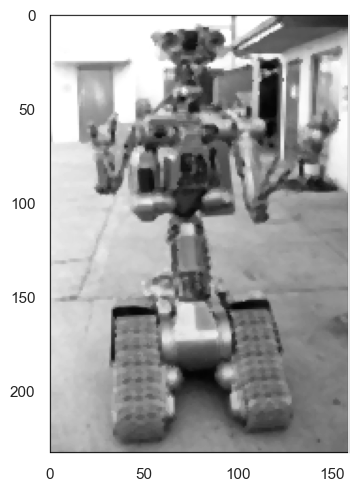

In [64]:
plt.imshow(gray_sp_rmed, cmap='gray', vmin=0, vmax=1);

### OpenCV

In [65]:
gray_sp_rmed_cv = cv.medianBlur(gray_sp, 3)

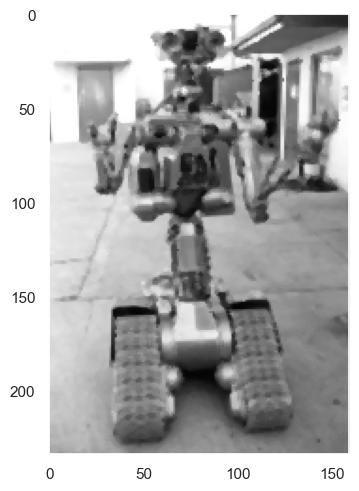

In [66]:
plt.imshow(gray_sp_rmed_cv, cmap='gray', vmin=0, vmax=1);

### Scipy: arbitrarily shaped neighborhoood (`selem`)

In [67]:
gray_sp_rmed_scp = scipy.ndimage.median_filter(gray_sp, 3)

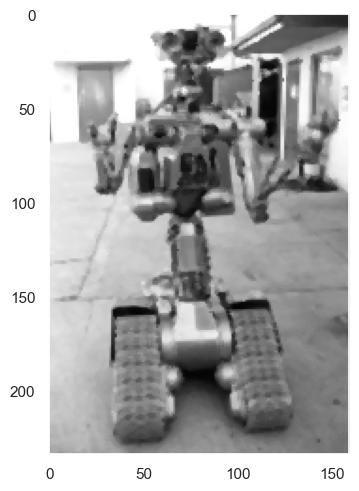

In [68]:
plt.imshow(gray_sp_rmed_scp, cmap='gray', vmin=0, vmax=1);

In [69]:
# Let's use cross-shaped neighborhood
selem = np.zeros((3, 3))
selem[1, :] = 1
selem[:, 1] = 1
selem

array([[0.00, 1.00, 0.00],
       [1.00, 1.00, 1.00],
       [0.00, 1.00, 0.00]])

In [70]:
gray_sp_rmedc_scp = skimage.filters.median(gray_sp, footprint=selem)

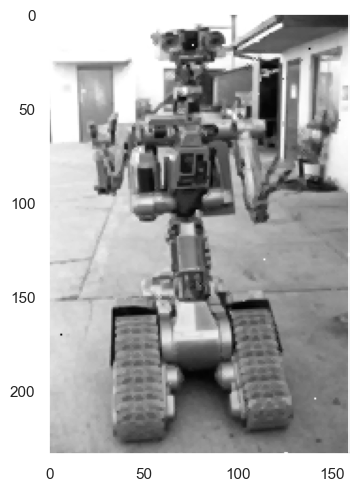

In [71]:
plt.imshow(gray_sp_rmedc_scp, cmap='gray', vmin=0, vmax=1);

In [72]:
# note the dtype change
gray_sp_rmed.dtype, gray_sp_rmed.shape, gray_sp_rmed.min(), gray_sp_rmed.max()

(dtype('float32'), (234, 160), 0.0, 1.0)

### scikit-image: arbitrarily shaped neighborhoood (`footprint`)

In [73]:
gray_sp_rmedc_ski = skimage.filters.median(gray_sp, footprint=selem)

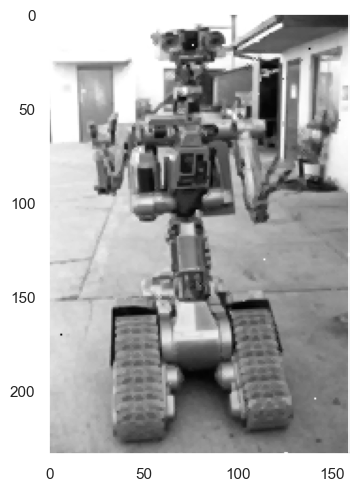

In [74]:
plt.imshow(gray_sp_rmedc_ski, cmap='gray', vmin=0, vmax=1);

# Non-linear filtering: Bilateral filter

$$
\tilde{I}(\bold{x}) = \frac{1}{W_p} \sum_{\bold{u} \in \Omega}{ f(\|I(\bold{u}) - I(\bold{x})\|) \cdot g(\|\bold{u}-\bold{v}\|) \cdot I(x,y)},
$$
where
- $\bold{x} = [x,y]^\top$
- $\bold{u} = [u,v]^\top$
- $f$ is a function that weighs how different intensities at positions $(x,y)$ and $(u,v)$ are - $f$ is usually a Gaussian function with $\sigma_\textrm{color}$,
- $g$ is a function that weighs how far apart positions $(x,y)$ and $(u,v)$ are - again, $g$ is usually a Gaussian function with $\sigma_\textrm{spatial}$,
- $\Omega$ is a local neigborhood around which the smoothing using $f$ and $g$ for pixel $(x,y)$ is performed,
- normalization factor $W_p$ ensures pixel weights sum to 1.0:
$$
W_p = \sum_{\bold{u} \in \Omega}{ f(\|I(\bold{u}) - I(\bold{x})\|) \cdot g(\|\bold{u}-\bold{v}\|) }
$$

In [75]:
def denoise_bilateral_interact(img, cax, sigma_color: float = 0.05, sigma_spatial: float = 2):
    img_r = skimage.restoration.denoise_bilateral(
        img,
        sigma_color = sigma_color,
        sigma_spatial = sigma_spatial,
        channel_axis = cax
    )
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img, cmap='gray', vmin=0., vmax=1.);
    axes[1].imshow(img_r, cmap='gray', vmin=0., vmax=1.);

ipywidgets.interact(
    denoise_bilateral_interact,
    img = ipywidgets.fixed(rgb_gn),
    cax = ipywidgets.fixed(2),
    sigma_color = (0., 0.3, 0.01),
    sigma_spatial = (0., 30.),
    continuous_update=False
);

interactive(children=(FloatSlider(value=0.05, description='sigma_color', max=0.3, step=0.01), FloatSlider(valu…

In [77]:
# salt & pepper noise
ipywidgets.interact(
    denoise_bilateral_interact,
    img = ipywidgets.fixed(rgb_sp),
    cax = ipywidgets.fixed(2),
    sigma_color = (0., 0.3, 0.01),
    sigma_spatial = (0., 30.),
    continuous_update = False
);

interactive(children=(FloatSlider(value=0.05, description='sigma_color', max=0.3, step=0.01), FloatSlider(valu…

## OpenCV

In [78]:
def denoise_bilateral_interact_cv(img, sigma_color: float = 128., sigma_spatial: float = 2.):
    img_r = cv.bilateralFilter(
        img,
        None,
        sigma_color,
        sigma_spatial
    )
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img, cmap='gray', vmin=0., vmax=255);
    axes[1].imshow(img_r, cmap='gray', vmin=0., vmax=255);

ipywidgets.interact(
    denoise_bilateral_interact_cv,
    img = ipywidgets.fixed(skimage.util.img_as_ubyte(rgb_sp)),
    sigma_color = (0., 255.),
    sigma_spatial = (0., 30.),
    continuous_update = True
);

interactive(children=(FloatSlider(value=128.0, description='sigma_color', max=255.0), FloatSlider(value=2.0, d…

# Non-linear filtering: Non-local means

Example from https://scikit-image.org/docs/dev/auto_examples/filters/plot_nonlocal_means.html#sphx-glr-auto-examples-filters-plot-nonlocal-means-py

In [81]:
# Algorithm needs to know approximate value of the standard deviation of the noise
sigma_est = np.mean(skimage.restoration.estimate_sigma(rgb_gn, channel_axis=2))
sigma_est

0.09276140255303189

In [82]:
# slow algorithm
rgb_gn_rnlm1 = skimage.restoration.denoise_nl_means(
    rgb_gn,
    h = 1.15 * sigma_est,  # threshold for comparing patch similarity
    fast_mode = False,
    patch_size = 5,
    patch_distance = 6,  # how far to search for similar patches
    channel_axis = 2
)

In [83]:
# slow algorithm, sigma provided
rgb_gn_rnlm2 = skimage.restoration.denoise_nl_means(
    rgb_gn,
    h = 0.8 * sigma_est,
    sigma = sigma_est,
    fast_mode = False,
    patch_size = 5,
    patch_distance = 6,
    channel_axis = 2
)

In [84]:
# fast algorithm
rgb_gn_rnlm3 = skimage.restoration.denoise_nl_means(
    rgb_gn,
    h = 0.8 * sigma_est,
    fast_mode = True,
    patch_size = 5,
    patch_distance = 6,
    channel_axis = 2
)

In [85]:
# fast algorithm, sigma provided
rgb_gn_rnlm4 = skimage.restoration.denoise_nl_means(
    rgb_gn,
    h = 0.6 * sigma_est,
    sigma = sigma_est,
    fast_mode = True,
    patch_size = 5,
    patch_distance = 6,
    channel_axis = 2
)

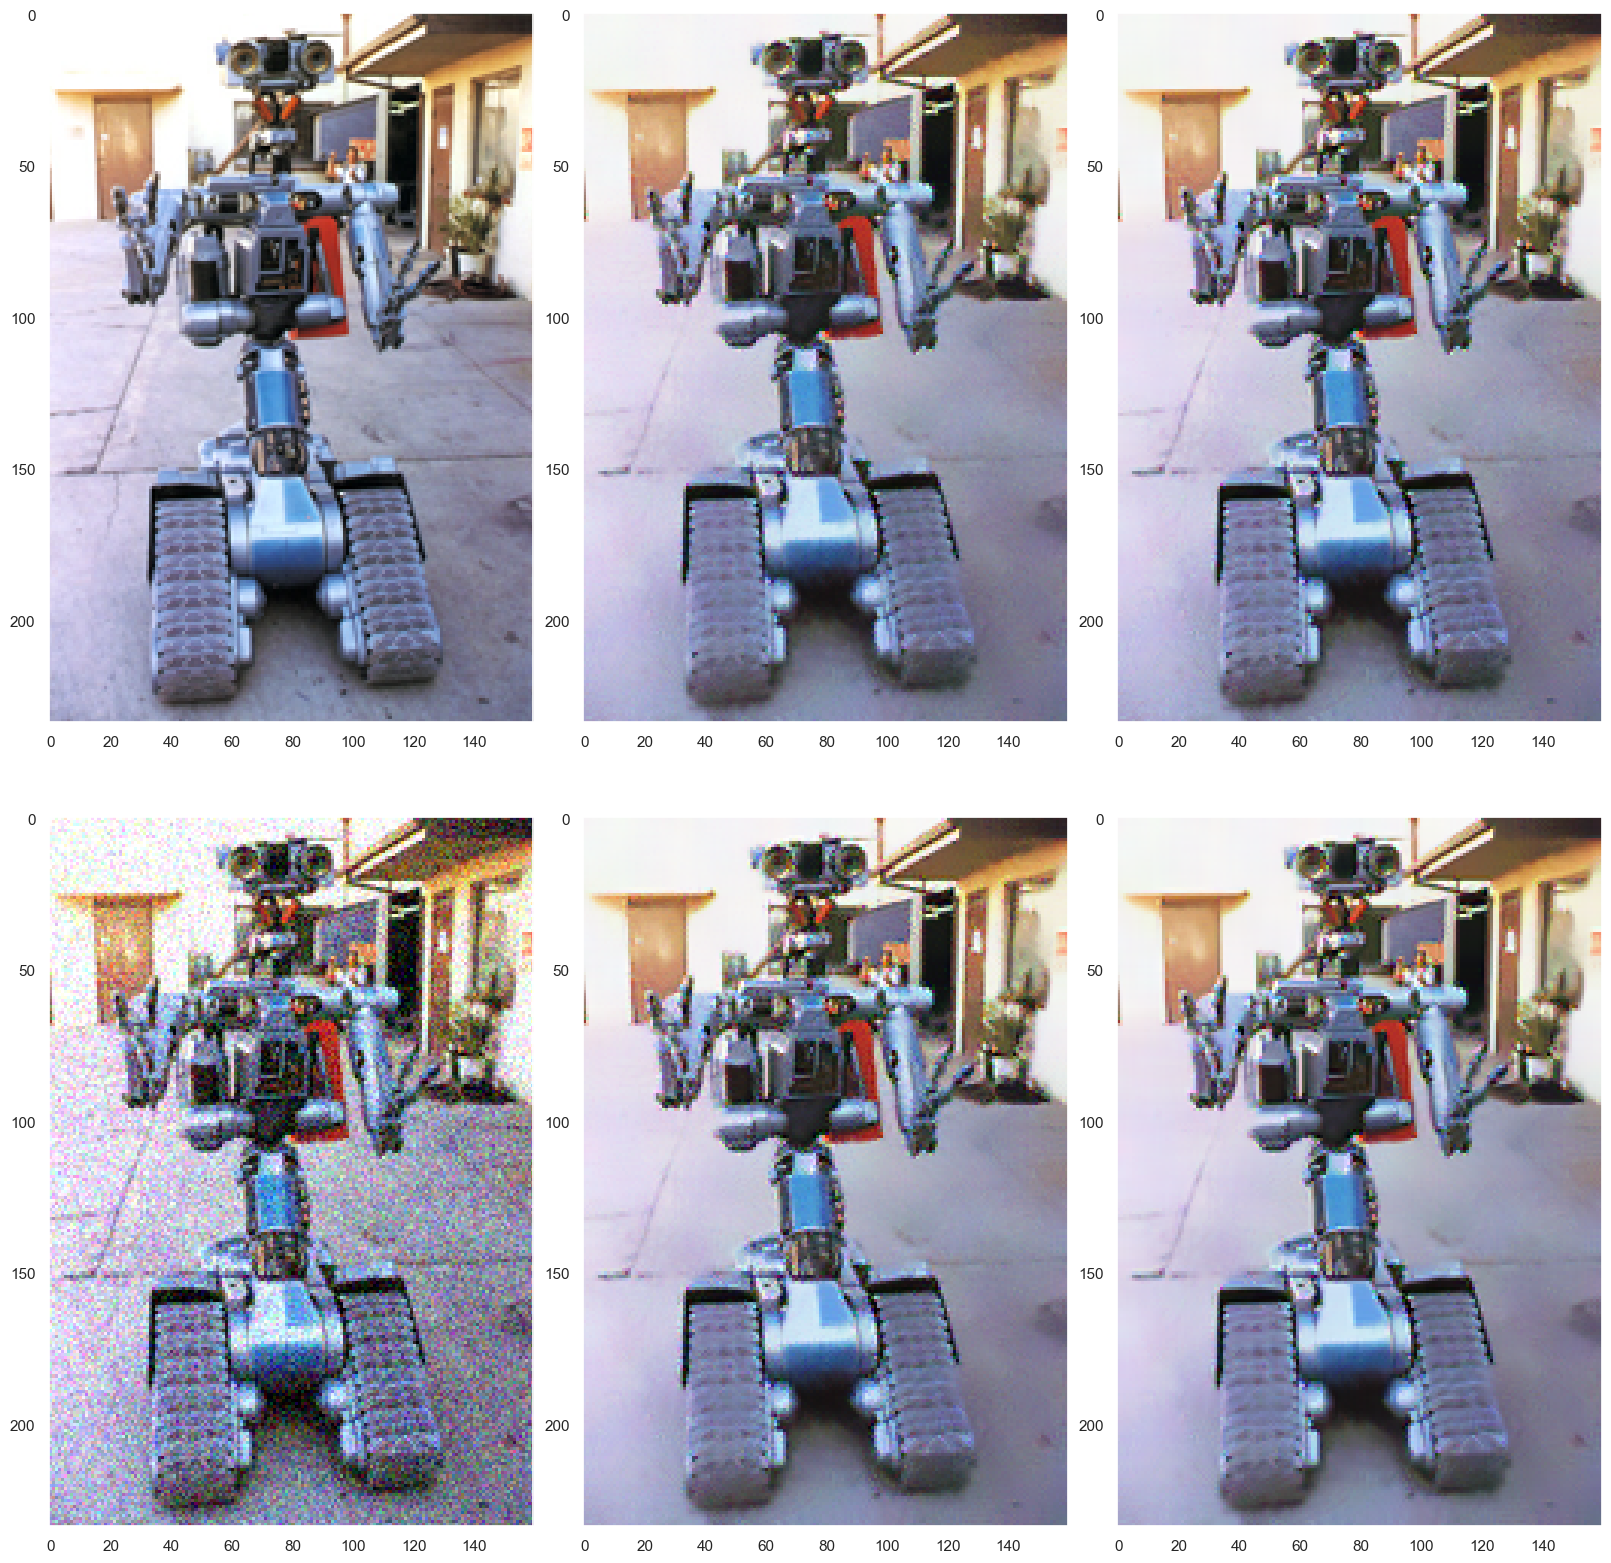

In [86]:
fig, axes = plt.subplots(2, 3, figsize=(16, 16))
axes[0, 0].imshow(rgb);
axes[0, 1].imshow(rgb_gn_rnlm1);
axes[0, 2].imshow(rgb_gn_rnlm2);
axes[1, 0].imshow(rgb_gn);
axes[1, 1].imshow(rgb_gn_rnlm3);
axes[1, 2].imshow(rgb_gn_rnlm4);